In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

In [10]:
EPOCH = 1
BATCH_SIZE = 50
LR = 0.001
DOWNLOAD_MINIST = True   # 已经下载好了

In [11]:
# 批训练 50samples，1channel，28*28（50，1, 28, 28）
train_data = torchvision.datasets.MNIST(
    root = './mnist',
    train = True,
    transform = torchvision.transforms.ToTensor(),  
    # (0,1)   (0-255) 这里面是灰度图不是rgb图，所以只有二维
    download = DOWNLOAD_MINIST
)

test_data = torchvision.datasets.MNIST(root='./mnist', train=True)

print(train_data)
print(test_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset MNIST
    Number of datapoints: 60000
    Root location: ./mnist
    Split: Train


torch.Size([60000, 28, 28])
torch.Size([60000])


/home/agent/anaconda3/envs/dlpy364/lib/python3.6/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/agent/anaconda3/envs/dlpy364/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


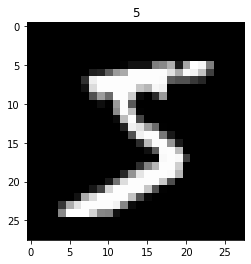

In [12]:
# plot one example: training data的第一张图片
print(train_data.train_data.size())   # torch.Size([60000, 28, 28])
print(train_data.train_labels.size())  # torch.Size([60000])
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title('%i' % train_data.train_labels[0])
plt.show()

In [13]:
# Data Loader for easy mini-batch return in training, the image batch shape will be (50, 1, 28, 28)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# 为了节约时间，我们测试时只测试前2000个
test_x = torch.unsqueeze(test_data.test_data, dim=1).type(torch.FloatTensor)[:2000]/255.
test_y = test_data.test_labels[:2000]

/home/agent/anaconda3/envs/dlpy364/lib/python3.6/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/agent/anaconda3/envs/dlpy364/lib/python3.6/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [14]:
# 和以前一样, 我们用一个 class 来建立 CNN 模型. 这个 CNN 整体流程是:
# 卷积(Conv2d) -> 激励函数(ReLU) -> 池化, 向下采样 (MaxPooling) -> 再来一遍 -> 展平多维的卷积成的特征图 -> 接入全连接层 (Linear) -> 输出
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels = 1,
                out_channels = 16,
                kernel_size = 5,
                stride = 1,
                padding = 2,  # if stride = 1, padding = (kernel_size-1)/2 = (5-1)/2
            ),   # -> (16, 28, 28)
            nn.ReLU(),   # -> (16,28,28)
            nn.MaxPool2d(kernel_size=2),   # -> (16,14,14)
        )
        
        self.conv2 = nn.Sequential(  # (16,14,14)
            nn.Conv2d(16, 32, 5, 1, 2),  # (32,14,14)
            nn.ReLU(),  # (32,14,14)
            nn.MaxPool2d(2),  # (32, 7, 7)
        )
        
        self.out = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)   # (batch, 32, 7, 7)
        x = x.view(x.size(0), -1)   # (batch, 32*7*7)
        output  = self.out(x)
        return output, x

In [15]:
cnn = CNN()
print(cnn)  # net architecture

optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [16]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

Please install sklearn for layer visualization


In [17]:
plt.ion()
# training and testing
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader

        output = cnn(b_x)[0]               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 50 == 0:
            test_output, last_layer = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.numpy()
            accuracy = float((pred_y == test_y.data.numpy()).astype(int).sum()) / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()

# print 10 predictions from test data
test_output, _ = cnn(test_x[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy()
print(pred_y, 'prediction number')
print(test_y[:10].numpy(), 'real number')

Epoch:  0 | train loss: 2.2956 | test accuracy: 0.20
Epoch:  0 | train loss: 0.4181 | test accuracy: 0.86
Epoch:  0 | train loss: 0.3578 | test accuracy: 0.91
Epoch:  0 | train loss: 0.2704 | test accuracy: 0.94
Epoch:  0 | train loss: 0.1701 | test accuracy: 0.94
Epoch:  0 | train loss: 0.4910 | test accuracy: 0.96
Epoch:  0 | train loss: 0.1118 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0360 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0405 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1347 | test accuracy: 0.96
Epoch:  0 | train loss: 0.0940 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0105 | test accuracy: 0.97
Epoch:  0 | train loss: 0.1440 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0785 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0217 | test accuracy: 0.97
Epoch:  0 | train loss: 0.0423 | test accuracy: 0.97


KeyboardInterrupt: 